In [1]:
import numpy as np
import tensorflow as tf

In [2]:
## load data
train_img,train_label=np.load(r"E:\projects\classification similarity using Siamese-Network\dataset\train_img.npy"),np.load(r"E:\projects\classification similarity using Siamese-Network\dataset\train_label.npy")
test_img,test_label=np.load(r"E:\projects\classification similarity using Siamese-Network\dataset\test_img.npy"),np.load(r"E:\projects\classification similarity using Siamese-Network\dataset\test_label.npy")

In [3]:
print(train_img.shape,train_label.shape)
print(test_img.shape,test_label.shape)

(119980, 2, 28, 28) (119980,)
(119980, 2, 28, 28) (119980,)


## Siamese Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda


## Creating Base model layers(for feature extraction)

def feature_extractor_network():
    input=Input(shape=(28,28,),name="input_layer")
    x=Flatten(name="flatten_input_layer")(input)
    x=Dense(128,activation='relu',name="first_dense_layer")(x)
    x=Dropout(0.1,name="first_dropout_layer")(x)
    x=Dense(128,activation='relu',name="second_dense_layer")(x)
    x=Dropout(0.1,name="second_dropout_layer")(x)
    x=Dense(128,activation='relu',name="third_dense_layer")(x)

    return Model(inputs=input,outputs=x)

feature_extractor=feature_extractor_network()
feature_extractor.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input_layer (Flatten (None, 784)               0         
_________________________________________________________________
first_dense_layer (Dense)    (None, 128)               100480    
_________________________________________________________________
first_dropout_layer (Dropout (None, 128)               0         
_________________________________________________________________
second_dense_layer (Dense)   (None, 128)               16512     
_________________________________________________________________
second_dropout_layer (Dropou (None, 128)               0         
_________________________________________________________________
third_dense_layer (Dense)    (None, 128)              

### custom distacne metrics 


In [16]:
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x,y=vects
    sum_square=K.sum(K.square(x-y),axis=1,keepdims=True)
    return K.sqrt(K.maximum(sum_square,K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1,shape2=shapes
    return (shape1[0],1)

In [17]:
## create model for comparing images

# Left layers
input_left=Input(shape=(28,28,),name="left_input")
feature_extractor_left=feature_extractor(input_left)

# Right layers
input_right=Input(shape=(28,28,),name="right_input")
feature_extractor_right=feature_extractor(input_right)

# Output Layer (Calculates distance between 2 image(left & right))
output=Lambda(euclidean_distance,name="output_layer",output_shape=eucl_dist_output_shape)([feature_extractor_left,feature_extractor_right])

# Siamese Model creation
siamese_model=Model(inputs=[input_left,input_right],outputs=output)
siamese_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 128)          133504      left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
output_layer (Lambda)           (None, 1)            0           functional_5[4][0]    

### Custom loss function 'Contrastive loss'

In [18]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true,y_pred):
        """ Contrastive loss from Hadsell-et-al.'06  @http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf """
        square_pred=K.square(y_pred)
        margin_square=K.square(K.maximum(margin-y_pred,0))  # outputs {max(among margin-y_pred & 0)}**2
        return (y_true*square_pred+(1-y_true)*margin_square)
    return contrastive_loss

### Compile & train model

In [28]:
from tensorflow.keras.optimizers import RMSprop

## compile
siamese_model.compile(loss=contrastive_loss_with_margin(margin=1),optimizer=RMSprop())

## training
train_left_img,train_right_img=train_img[:,0],train_img[:,1]
val_left_img,val_right_img=test_img[:,0],test_img[:,1]

history=siamese_model.fit([train_left_img,train_right_img],train_label,epochs=50,batch_size=128,validation_data=([val_left_img,val_right_img],test_label),verbose=1)

Epoch 1/50
938/938 [==============================] - 6s 6ms/step - loss: 0.0489 - val_loss: 0.0431
Epoch 2/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0485 - val_loss: 0.0430
Epoch 3/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0486 - val_loss: 0.0417
Epoch 4/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0479 - val_loss: 0.0420
Epoch 5/50
938/938 [==============================] - 7s 7ms/step - loss: 0.0480 - val_loss: 0.0436
Epoch 6/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0477 - val_loss: 0.0433
Epoch 7/50
938/938 [==============================] - 6s 6ms/step - loss: 0.0473 - val_loss: 0.0413
Epoch 8/50
938/938 [==============================] - 7s 7ms/step - loss: 0.0469 - val_loss: 0.0420
Epoch 9/50
938/938 [==============================] - 6s 7ms/step - loss: 0.0468 - val_loss: 0.0427
Epoch 10/50
938/938 [==============================] - 7s 7ms/step - loss: 0.0462 - val_loss: 0.0412

### Model Evaluation

In [29]:
def compute_accuracy(y_true, y_pred):
    ''' Compute classification accuracy with fixed threshold on distances '''
    pred=y_pred.ravel()<0.5
    return np.mean(pred==y_true)


loss = siamese_model.evaluate(x=[val_left_img,val_right_img],y=test_label)

y_pred_train = siamese_model.predict([train_left_img,train_right_img])
train_accuracy = compute_accuracy(train_label, y_pred_train)

y_pred_test = siamese_model.predict([val_left_img,val_right_img])
test_accuracy = compute_accuracy(test_label,y_pred_test)

print("Loss = {}, Train Accuracy = {}% Test Accuracy = {}%".format(round(loss,3),round(train_accuracy*100,2),round(test_accuracy*100,2)))

3750/3750 [==============================] - 7s 2ms/step - loss: 0.0363
Loss = 0.036, Train Accuracy = 95.33% Test Accuracy = 95.33%


### Plot metics

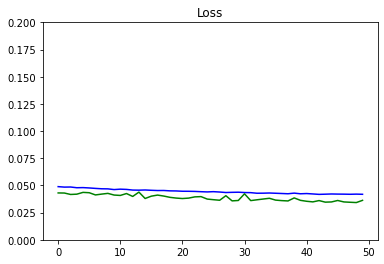

In [30]:
import matplotlib.pyplot as plt

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

## Visualize predictions

In [31]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


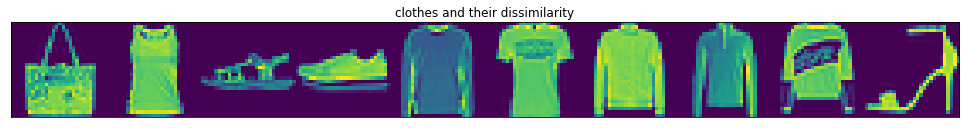

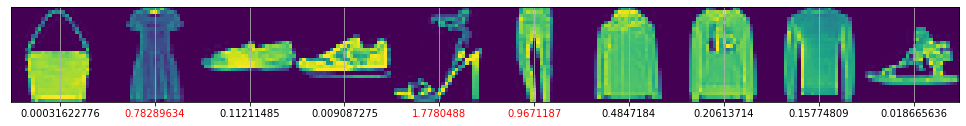

In [35]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_left_img[indexes],train_right_img[indexes],y_pred_train[indexes],train_label[indexes],"clothes and their dissimilarity",10)